In [64]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [133]:
import copy
from hexalattice.hexalattice import *


def target_height_to_box_dim_RDG6(target_height):
    '''Returns cell width, depth, height given target height'''
    return target_height*2, int(target_height*4*np.sqrt(3)/3), int(target_height*np.sqrt(2)/np.sqrt(3))

def hex_indices_to_coords(x,y):
    return np.array([x*3/(2*np.sqrt(3)), y - 0.5*x])

# Visualize data
def visualize_data(N, nu, threshold, shape_name):
    shape_name_str = shape_name
    N_str = str(N)
    if shape_name == "Cube":
        shape_name_str = "Cube\\x2_widths"
        N_str = str(N)
        width = 2*N
    elif shape_name == "RDG4":
        shape_name_str = "RDG_square_int"
        N_str = f"{int(2*N)}x{int(2*N)}x{int(N*np.sqrt(2))}"
        width = int(2*N)
    elif shape_name == "RDG6":
        visualize_hexagon_data(N, nu, threshold)
        return
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG4, RDG6)")
        return

    filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((width, width))
    print("Datapoints:",len(strike_data_str))

    for point in strike_data_str:
        point = point.split(',')
        x_coord = ...
        y_coord = ...
        if shape_name == "Cube":
            x_coord = point[1]
            y_coord = point[2]
        elif shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = point[0]
            y_coord = point[1]
        x_coord = x_coord.strip()
        if shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = x_coord.strip('(')
            x_coord = x_coord.strip()
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1

    cmap = matplotlib.cm.viridis
    plt.imshow(strike_data, cmap=cmap)
    plt.colorbar()
    plt.show()


# Visualize hexagon data
def visualize_hexagon_data(N, nu, threshold):
    def float_to_rgb_color(value, cmap_name='viridis'):
        value = min(0.9999999999, max(0, value))
        
        cmap = plt.get_cmap(cmap_name)
        
        rgba = cmap(value)
        
        return [rgba[0], rgba[1], rgba[2]]


    width, depth, height = target_height_to_box_dim_RDG6(N)

    filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\RDG_hex_int\\{width}x{depth}x{height}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    width_max = width*2+1
    depth_max = depth*3//2
    strike_data = np.zeros((width_max, depth_max))
    print("Datapoints:", len(strike_data_str))

    for point in strike_data_str:
        point = point.split(',')
        x_coord = point[0]
        y_coord = point[1]
        x_coord = x_coord.strip()
        x_coord = x_coord.strip('(')
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1

    strike_data /= np.max(strike_data)


    hex_centers, _ = create_hex_grid(nx=width_max,
                                     ny=depth_max,
                                     do_plot=False)
    x_hex_coords = hex_centers[:, 0]
    x_hex_coords = np.array([val - i//(width_max) + (i*1)//(2*width_max) for i, val in enumerate(x_hex_coords)])
    y_hex_coords = hex_centers[:, 1]


    colors = np.array([float_to_rgb_color(strike_data[x_pos, y_pos], cmap_name='plasma') for y_pos in range(depth_max) for x_pos in range(width_max)])
    edge_colors = copy.deepcopy(colors)

    new_edge_colors = []
    new_colors = []
    new_x_hex_coords = []
    new_y_hex_coords = []

        
    effective_width = width//2+1
    y_pos_cells = width*2//3
    effective_depth = y_pos_cells * np.sqrt(3)/2
    diff = int(effective_depth - effective_width)
    effective_width += diff
    
    total_weight = np.sum(strike_data)
    mid_x = np.sum(np.arange(strike_data.shape[0])[:, None] * strike_data) / total_weight
    mid_y = np.sum(np.arange(strike_data.shape[1]) * strike_data) / total_weight
    mid_x_coord = x_hex_coords[int(mid_x) + int(mid_y) * width_max]
    mid_y_coord = y_hex_coords[int(mid_x) + int(mid_y) * width_max]
    
    left_boundary = mid_y_coord - width/2
    right_boundary = mid_y_coord + width/2
    top_boundary = mid_x_coord - depth/2
    bottom_boundary = mid_x_coord + depth/2
    print(width, depth, height)

    for x_pos in range(width_max):
        for y_pos in range(depth_max):
            if y_hex_coords[y_pos + y_pos * width_max] < left_boundary or \
                y_hex_coords[y_pos + y_pos * width_max] > right_boundary or \
                x_hex_coords[x_pos + y_pos * width_max] < top_boundary or \
                x_hex_coords[x_pos + y_pos * width_max] > bottom_boundary:
                continue
            new_edge_colors.append(edge_colors[x_pos + y_pos * width_max])
            new_colors.append(colors[x_pos + y_pos * width_max])
            new_x_hex_coords.append(x_hex_coords[x_pos + y_pos * width_max])
            new_y_hex_coords.append(y_hex_coords[y_pos + y_pos * width_max])

    new_edge_colors = np.array(new_edge_colors)
    new_colors = np.array(new_colors)
    new_x_hex_coords = np.array(new_x_hex_coords)
    new_y_hex_coords = np.array(new_y_hex_coords)

    plot_single_lattice_custom_colors(new_y_hex_coords, new_x_hex_coords,
                                        face_color=new_colors,
                                        edge_color=new_colors,
                                        min_diam=0.99,
                                        plotting_gap=0.08,
                                        rotate_deg=30)
    plt.show()


In [180]:
from scipy.stats import chi2

# Variance of 2D data
def error_from_indices(pos_a, pos_b):
    '''positions assumed to be (x-pos, y-pos)'''
    euclidian_pos_a = hex_indices_to_coords(*pos_a)
    euclidian_pos_b = hex_indices_to_coords(*pos_b)
    error = np.sum((euclidian_pos_a - euclidian_pos_b)**2)
    return error

def calc_variance(N, nu, threshold, shape_name, print_output=False):
    if shape_name == "Cube":
        shape_name_str = "Cube\\x2_widths"
        N_str = str(N)
        strike_arr_width = 2*N
    elif shape_name == "RDG4":
        shape_name_str = "RDG_square_int"
        N_str = f"{2*N}x{2*N}x{int(N*np.sqrt(2))}"
        strike_arr_width= 2*N
    elif shape_name == "RDG6":
        shape_name_str = "RDG_hex_int"
        width, depth, height = target_height_to_box_dim_RDG6(N)
        N_str = f"{width}x{depth}x{height}"
        strike_arr_width = max(width*2+1, depth*3//2)
    else:
        print(f"{shape_name} is not one of the stored grid-types (Cube, RDG4, RDG6)")
        return

    filename_strike = f"C:\\Users\\gabriel\\Desktop\\Capstone\\data\\{shape_name_str}\\{N_str}_{nu}_{threshold}_strikedata.txt"
    strike_file = open(filename_strike,'r')
    strike_data_str = strike_file.read()
    strike_data_str = strike_data_str.split('#')[:-1]

    strike_data = np.zeros((strike_arr_width, strike_arr_width), dtype=int)

    for i, point in enumerate(strike_data_str):
        point = point.split(',')
        if shape_name == "Cube":
            x_coord = point[1]
            y_coord = point[2]
            if i == 0:
                height = int(point[0].strip('(').strip())
                real_height = height

        elif shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = point[0]
            y_coord = point[1]
            if i == 0:
                height = int(point[2].strip(')').strip())
                if shape_name == "RDG4":
                    real_height = height / np.sqrt(2)
                else:
                    real_height = height * np.sqrt(3)/np.sqrt(2)
        x_coord = x_coord.strip()
        if shape_name == "RDG4" or shape_name == "RDG6":
            x_coord = x_coord.strip('(')
        y_coord = y_coord.strip()
        y_coord = y_coord.strip(')')
        strike_data[int(x_coord), int(y_coord)] += 1
    
    indices = np.nonzero(strike_data)
    y_indices, x_indices = indices

    if shape_name == "RDG6":
        # Convert data to a list of x-positions and one of y-positions

        # height = sqrt(3) * radius = 1
        # radius = 1/sqrt(3)
        # x_pos_change = 3/2 * radius = 3/(2*sqrt(3))
        # A vertical move will only change y-pos with +1
        # A horizontal move will move y-pos with -1/2, and x-pos with 3/(2*sqrt(3))
        
        # Collect all strike positions in euclidian coordinates 
        all_positions = []
        for i in range(len(indices[0])):
                y_i, x_i = indices[0][i], indices[1][i]
                all_positions.extend([hex_indices_to_coords(x_i, y_i)]*strike_data[y_i, x_i])
                
        x_positions = [pos[0] for pos in all_positions]
        y_positions = [pos[1] for pos in all_positions]
        mean_x_pos = np.mean(x_positions)
        mean_y_pos = np.mean(y_positions)
        var_x_pos = np.var(x_positions)
        var_y_pos = np.var(y_positions)
        mean_pos = mean_x_pos, mean_y_pos

        # make a list of all errors
        all_errors = []
        for pos in all_positions:
            all_errors.append(error_from_indices(pos, mean_pos))

        overall_var = np.mean(all_errors)/2
        var_overall_var = np.var(all_errors)

    else:
        # sum all rows
        x_data_flat = np.sum(strike_data, axis=1)
        # sum all columns
        y_data_flat = np.sum(strike_data, axis=0)

        # Produce a list where number of elements with index value is proportional to strike_data value
        multiple_x_indices = []
        for x in x_indices:
            multiple_x_indices.extend([x]*x_data_flat[x])

        multiple_y_indices = []
        for y in y_indices:
            multiple_y_indices.extend([y]*y_data_flat[y])

        # Average x and y pos, variance of center
        mean_x_pos = np.mean(multiple_x_indices)
        mean_y_pos = np.mean(multiple_y_indices)
        var_x_pos = np.var(multiple_x_indices)
        var_y_pos = np.var(multiple_y_indices)

        # Overall variance (average error)
        x_distances = []
        y_distances = []
        all_errors = []
        for x in range(strike_arr_width):
            for y in range(strike_arr_width):
                if strike_data[x,y] > 0:
                    # Error in x, y, and overall 
                    x_distances.extend([(x - mean_x_pos)**2] * strike_data[y,x])
                    y_distances.extend([(y - mean_y_pos)**2] * strike_data[y,x])
                    all_errors.extend([((x - mean_x_pos)**2 + (y - mean_y_pos)**2)] * strike_data[y,x])
        
        # Average error
        var_x_pos = np.mean(x_distances)
        var_y_pos = np.mean(y_distances)
        overall_var = np.mean(np.array(all_errors)/2)

    if print_output:
        print("Datapoints:", len(strike_data_str))
        print(f"Mean x-pos: {mean_x_pos}")
        print(f"Mean y-pos: {mean_y_pos}")
        print(f"Var x-pos: {var_x_pos}")
        print(f"Var y-pos: {var_y_pos}")
        print(f"Overall variance: {overall_var}")
        
        if shape_name != "RDG6":
            print("Variance of variances:")
            print(np.var(x_distances))
            print(np.var(y_distances))
            print(np.var(np.array(all_errors)/np.sqrt(2)))
        else:
            print(f"Variance of var: {var_overall_var}")

            
        print()
        print("height of box in cells:", height)
        print("height of box in distance:", real_height)

    # Calculate 95% confidence interval for variance
    sample_variance = overall_var
    dof = len(strike_data_str) - 1
    a, b = chi2.ppf(0.975, dof), chi2.ppf(0.025, dof)

    lower_bound = (dof * sample_variance) / a
    upper_bound = (dof * sample_variance) / b
    
    return overall_var, lower_bound, upper_bound, var_x_pos, var_y_pos, mean_x_pos, mean_y_pos, all_errors

Datapoints: 2350
30 34 12


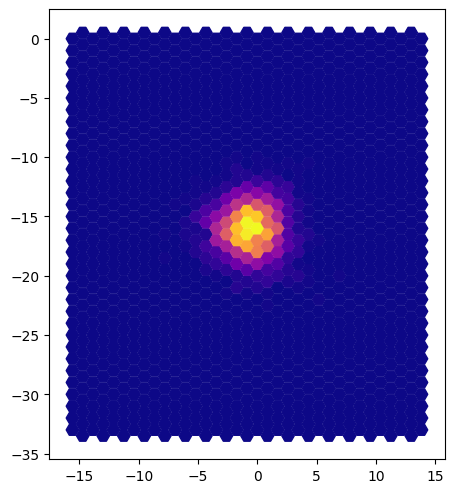

0.0021355923759878797


In [ ]:
visualize_data(15, 6, 0.001, "RDG6")

In [69]:
calc_variance(30, 6, 0.001, "Cube", True);

Datapoints: 1369
Mean x-pos: 30.092398969022028
Mean y-pos: 30.018780874266007
Var x-pos: 7.684739017744115
Var y-pos: 7.317963249399568
Overall variance: 7.50135113357184
Variance of variances:
121.17332338130859
117.9887121774559
115.49927684755005

height of box in cells: 29
height of box in distance: 29


In [80]:
# Cube 30 means 60x60x30

# RDG4 30 means 45x45x30 
# side step is (r,r,0) -> sqrt(2)r = 1 -> r=1/sqrt(2)=sqrt(2)/2
# step up is (r,0,0) -> r -> 1/sqrt(2)
# so 45x45x30 is in rectangular coords 45x45x(30/sqrt(2)) -> 45x45x21.22

# RDG6 30 means 30x30x(11)
# side step is (r, r, 0) -> sqrt(2)r = 1 -> r=1/sqrt(2)
# two forward steps are (2r, 0, 0) = 2r = sqrt(2)
# step up is (r, r, r) -> sqrt(3)r = sqrt(3)/sqrt(2)
# so a x b x c -> (a*sqrt(2)) x b x (c*sqrt(3)/sqrt(2))

# For a given target width X
# I need Cube X x X x X/2

# q/sqrt(2) = X/2
# I need RDG4 X x X x X*sqrt(2)/2

# I need RDG6 X/sqrt(2) x X x X*sqrt(2)/(2*sqrt(3))

target_width = 40


print("Cell dimensions:")
print(f"Cube: {target_width}x{target_width}x{target_width//2}  ->  ({target_width}x{target_width}x{target_width//2})")
print(f"RDG4: {target_width}x{target_width}x{int(target_width*np.sqrt(2)//2)}  ->  ({target_width}x{target_width}x{round(int(target_width*np.sqrt(2)//2)/np.sqrt(2), 2)})")
print(f"RDG6: {target_width}x{int(target_width*2*np.sqrt(3)/3)}x{int(target_width*np.sqrt(2)//(2*np.sqrt(3)))}  ->  ({target_width}x{round(int(target_width*2*np.sqrt(3)/3)*3/(2*np.sqrt(3)), 2)}x{round(int(target_width*np.sqrt(2)//(2*np.sqrt(3)))*np.sqrt(3)/np.sqrt(2), 2)})")


target_height = 15

print("Cell dimensions:")
print(f"Cube: {target_height*2}x{target_height*2}x{target_height}  ->  ({target_height*2}x{target_height*2}x{target_height})")
print(f"RDG4: {target_height*2}x{target_height*2}x{int(target_height*np.sqrt(2))}  ->  ({target_height*2}x{target_height*2}x{round(int(target_height*2/np.sqrt(2))/np.sqrt(2), 2)})")
print(f"RDG6: {target_height*2}x{int(target_height*4*np.sqrt(3)/3)}x{int(target_height*np.sqrt(2)/np.sqrt(3))}  ->  ({target_height*2}x{round(int(target_height*4*np.sqrt(3)/3)*3/(2*np.sqrt(3)), 2)}x{round(int(target_height*np.sqrt(2)/np.sqrt(3))*np.sqrt(3)/np.sqrt(2), 2)})")

Cell dimensions:
Cube: 40x40x20  ->  (40x40x20)
RDG4: 40x40x28  ->  (40x40x19.8)
RDG6: 40x46x16  ->  (40x39.84x19.6)
Cell dimensions:
Cube: 30x30x15  ->  (30x30x15)
RDG4: 30x30x21  ->  (30x30x14.85)
RDG6: 30x34x12  ->  (30x29.44x14.7)


In [ ]:
# Compare the variances, and variance of variances, for a given target width

# width = 1
# size = 1/sqrt(3)
# vertical_change = 3/2 * size = 3/(2*sqrt(3))


Datapoints: 18362


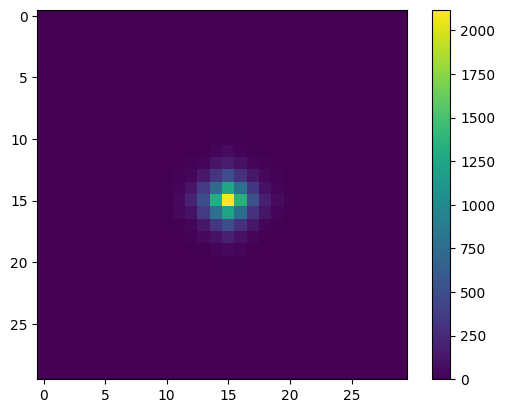

Datapoints: 5846


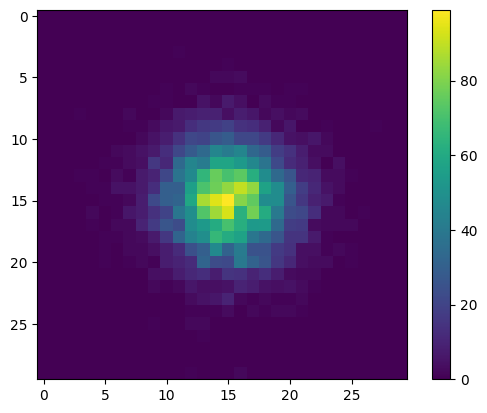

Datapoints: 2350
30 34 12


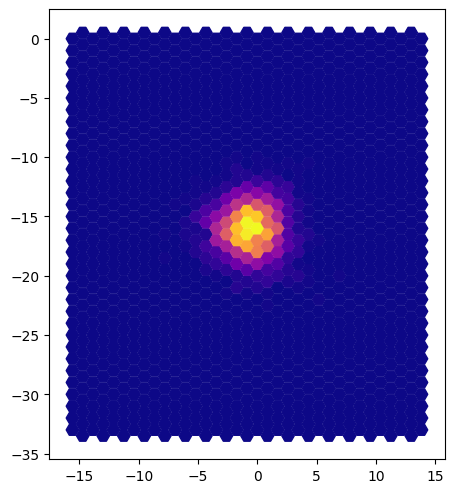

Cube stats
Datapoints: 18362
Mean x-pos: 14.964961948007538
Mean y-pos: 14.974629262829838
Var x-pos: 2.0616084980913367
Var y-pos: 1.9928967207290733
Overall variance: 2.027252609410205
Variance of variances:
12.307101740298062
11.754218439238015
11.89120217167848

height of box in cells: 14
height of box in distance: 14


RDG4 stats
Datapoints: 5846
Mean x-pos: 14.98070104901495
Mean y-pos: 15.061191188468861
Var x-pos: 9.715293333229202
Var y-pos: 9.646673785257068
Overall variance: 9.680983559243135
Variance of variances:
171.42262534797499
169.6027974462997
160.14655974935084

height of box in cells: 20
height of box in distance: 14.14213562373095


RDG6 stats
Datapoints: 2350
Mean x-pos: 21.073161984938533
Mean y-pos: 14.507021276595745
Var x-pos: 3.264929062924402
Var y-pos: 3.2930358080579447
Overall variance: 3.310582718444591
Variance of var: 65.05516950071218

height of box in cells: 11
height of box in distance: 13.472193585307478


In [193]:
target_analysis_height = 15
visualize_data(target_analysis_height, 6, 0.001, "Cube")
visualize_data(target_analysis_height, 6, 0.001, "RDG4")
visualize_data(target_analysis_height, 6, 0.001, "RDG6")

print("Cube stats")
calc_variance(target_analysis_height, 6, 0.001, "Cube", True);
print("\n\nRDG4 stats")
calc_variance(target_analysis_height, 6, 0.001, "RDG4", True);
print("\n\nRDG6 stats")
calc_variance(target_analysis_height, 6, 0.001, "RDG6", True);

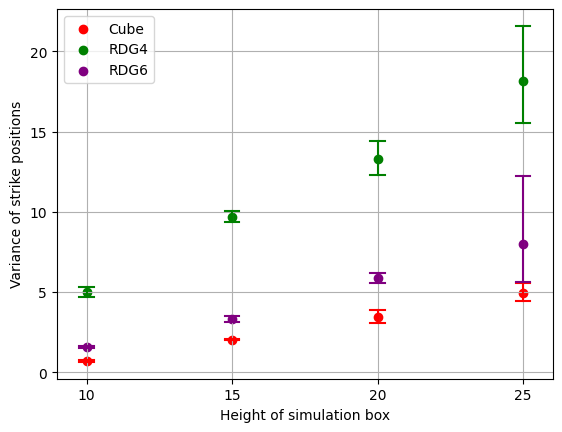

In [195]:
target_heights = [10, 15, 20, 25]
variances = {"Cube": [], "RDG4": [], "RDG6": []}
lower_bounds = {"Cube": [], "RDG4": [], "RDG6": []}
upper_bounds = {"Cube": [], "RDG4": [], "RDG6": []}

for target_height in target_heights:
    for grid_type in ["Cube", "RDG4", "RDG6"]:
        results = calc_variance(target_height, 6, 0.001, grid_type)
        variances[grid_type].append(results[0])
        lower_bounds[grid_type].append(results[1])
        upper_bounds[grid_type].append(results[2])


whisker_width=0.5
plt.scatter(target_heights, variances["Cube"], color="red", label="Cube")
for i in range(len(target_heights)):
    plt.plot([target_heights[i], target_heights[i]], [lower_bounds["Cube"][i], upper_bounds["Cube"][i]], color="red")
    plt.plot([target_heights[i]-whisker_width/2, target_heights[i]+whisker_width/2], [lower_bounds["Cube"][i], lower_bounds["Cube"][i]], color="red")
    plt.plot([target_heights[i]-whisker_width/2, target_heights[i]+whisker_width/2], [upper_bounds["Cube"][i], upper_bounds["Cube"][i]], color="red")
plt.scatter(target_heights, variances["RDG4"], color = "green", label="RDG4")
for i in range(len(target_heights)):
    plt.plot([target_heights[i], target_heights[i]], [lower_bounds["RDG4"][i], upper_bounds["RDG4"][i]], color="green")
    plt.plot([target_heights[i]-whisker_width/2, target_heights[i]+whisker_width/2], [lower_bounds["RDG4"][i], lower_bounds["RDG4"][i]], color="green")
    plt.plot([target_heights[i]-whisker_width/2, target_heights[i]+whisker_width/2], [upper_bounds["RDG4"][i], upper_bounds["RDG4"][i]], color="green")
plt.scatter(target_heights, variances["RDG6"], color = "purple", label="RDG6")
for i in range(len(target_heights)):
    plt.plot([target_heights[i], target_heights[i]], [lower_bounds["RDG6"][i], upper_bounds["RDG6"][i]], color="purple")
    plt.plot([target_heights[i]-whisker_width/2, target_heights[i]+whisker_width/2], [lower_bounds["RDG6"][i], lower_bounds["RDG6"][i]], color="purple")
    plt.plot([target_heights[i]-whisker_width/2, target_heights[i]+whisker_width/2], [upper_bounds["RDG6"][i], upper_bounds["RDG6"][i]], color="purple")
plt.xticks(target_heights)
plt.xlabel("Height of simulation box")
plt.ylabel("Variance of strike positions")
plt.grid()
plt.legend()
plt.show()


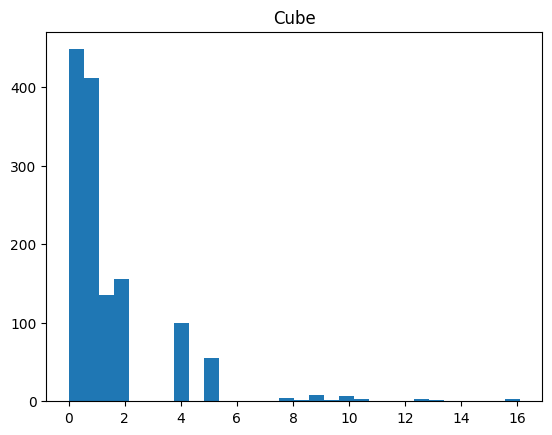

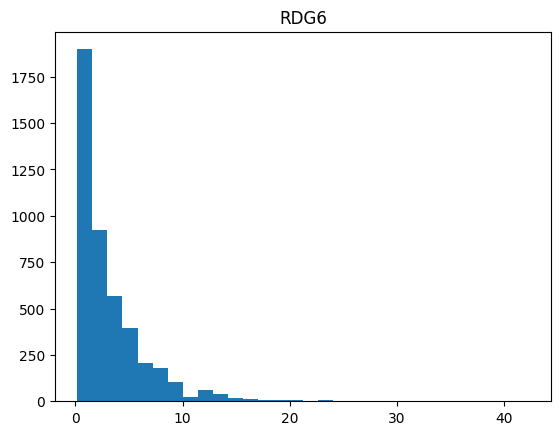

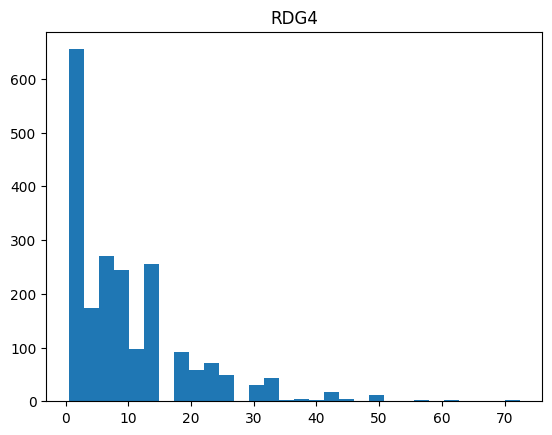

In [191]:
# Distance plots
grid_types = ["Cube", "RDG6", "RDG4"]
for grid_type in grid_types:
    target_height = 10

    all_errors = calc_variance(target_height, 6, 0.001, grid_type)[7]

    plt.hist(all_errors, bins=30)
    plt.title(grid_type)
    plt.show()

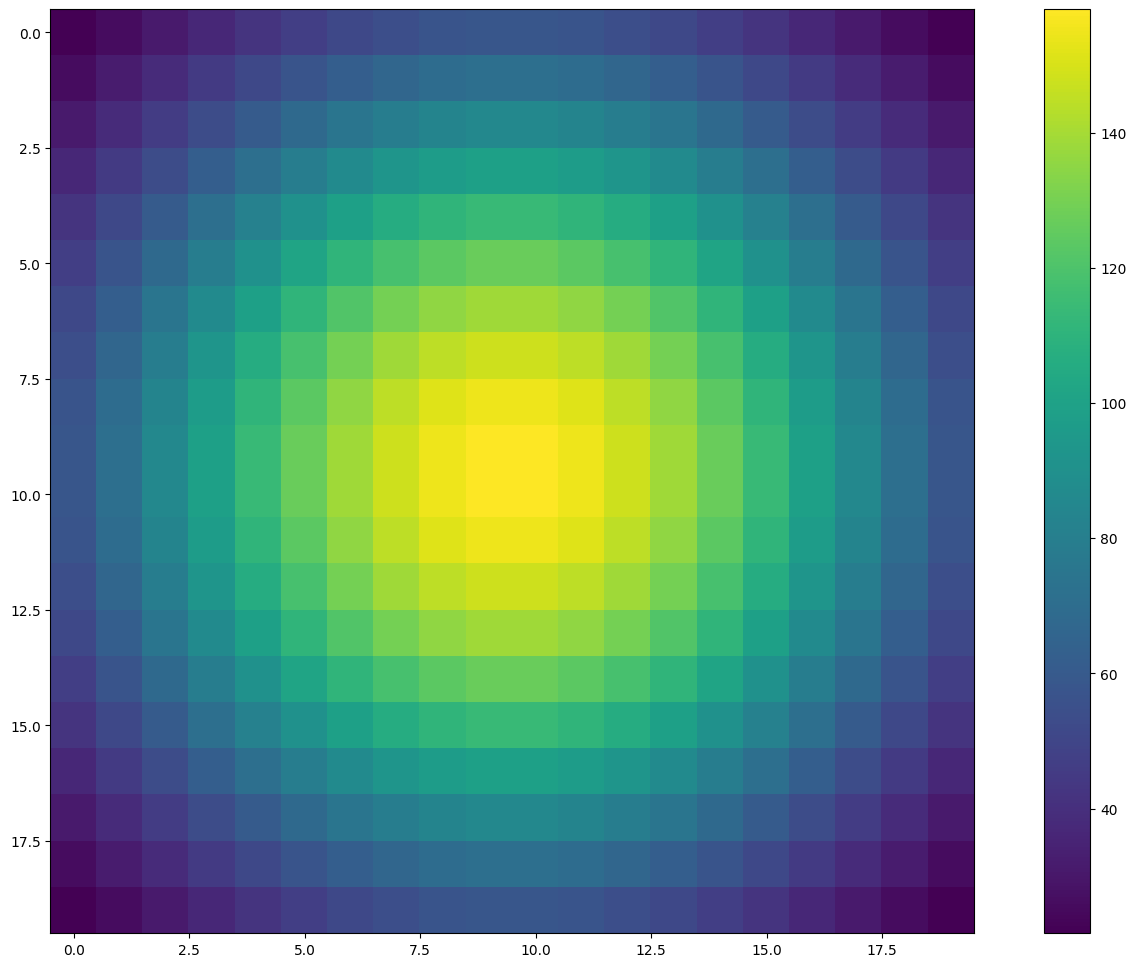

158
Average distances
24.579113924050635
24.579113924050635
24.579113924050635
Variances:
672.461065443673
672.4610654436729
671.9032629628172


In [ ]:

from scipy.stats import multivariate_normal

multivariate_normal_obj = multivariate_normal([0, 0], [[2.0, 0], [0, 2]])

grid = np.array((20,20))
mg = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
grid = multivariate_normal_obj.pdf(np.dstack(mg)) * 2000
cmap = matplotlib.cm.viridis
fig = plt.figure(figsize=(18,12))
plt.imshow(grid, cmap=cmap)
plt.colorbar()
plt.show()

grid = np.array(grid, dtype=int)

print(np.max(grid))

x_indices, y_indices = np.nonzero(grid)

#print("x_indices", x_indices)

x_data_flat = np.sum(grid, axis=1, dtype=int)
y_data_flat = np.sum(grid, axis=0, dtype=int)
#print(x_data_flat)
multiple_x_indices = []
for x in x_indices:
    multiple_x_indices.extend([x]*x_data_flat[x])

multiple_y_indices = []
for y in y_indices:
    multiple_y_indices.extend([y]*y_data_flat[y])

#print("multiple_x_indices", multiple_x_indices)
mean_x_pos = np.mean(multiple_x_indices)
mean_y_pos = np.mean(multiple_y_indices)
var_x_pos = np.var(multiple_x_indices)
var_y_pos = np.var(multiple_y_indices)

x_distances = []
y_distances = []
all_errors = []
for x in range(20):
    for y in range(20):
        x_distances.extend([(x - mean_x_pos)**2] * grid[x,y])
        y_distances.extend([(y - mean_y_pos)**2] * grid[x,y])
        all_errors.extend([((x - mean_x_pos)**2 + (y - mean_y_pos)**2)] * grid[x,y])


print("Average distances")
print(np.mean(x_distances))
print(np.mean(y_distances))
print(np.mean(all_errors)/2)
print("Variances:")
print(np.var(x_distances))
print(np.var(y_distances))
print(np.var(np.array(all_errors)/np.sqrt(2)))